# Homework 3

In [1]:
import cv2
import PIL
import torch
import numpy as np
import torchvision
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from PIL import Image

from sklearn import svm, neighbors
from scipy.signal import savgol_filter
from sklearn.metrics import accuracy_score, confusion_matrix

from torchvision import datasets, transforms

from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split


## Useful links about pytorch
[How to use pytorch datasets and dataloaders?](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)  
[How to do data transformations?](https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html)  
[How to build model using pytorch?](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)  
[How to do back propagation?](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)  
[How to use optimization algorithm?](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html)  

## EDA
### The distribution of train set and test set is similar. The proportion of each class is approximately the same therefore the metric I choose for this task will simply be the accuracy score. Since the input is an image, the number of features will be the total number of pixels which is 28 * 28 = 784. Based on the observation, the number of pixels that are 0 is around 600 therefore the hidden units of this layer should be greater than 784 - 600 = 184 which makes 256 hidden units a good option (the model will extract enough information yet still fast enough for training). I used non-linear activation function ReLU in between the 2 layers.
### Then I calculated the mean and standard deviation for normalizing the pixel from (0, 255) to (-1, 1).

Train size: 60000


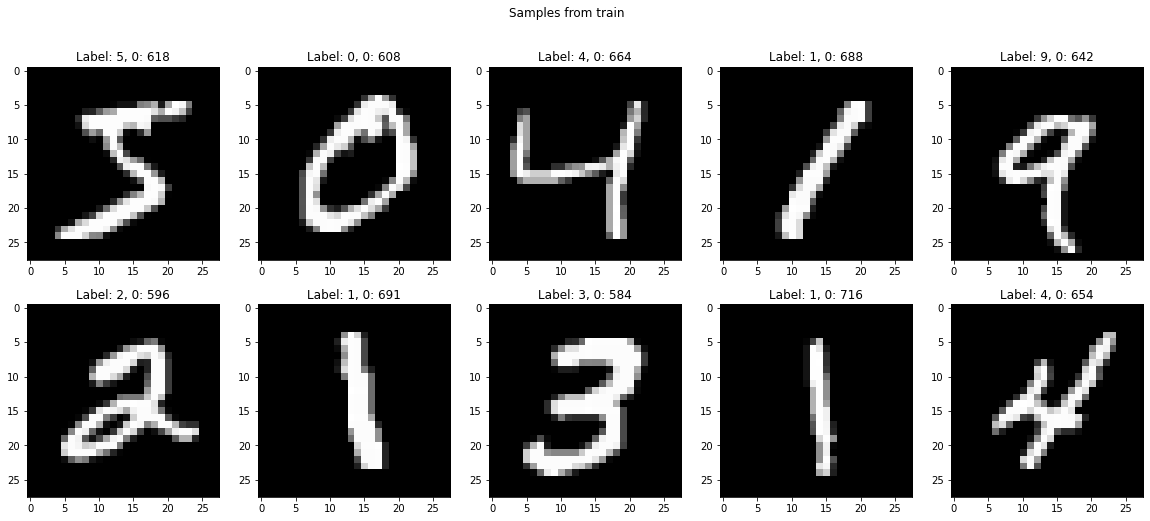

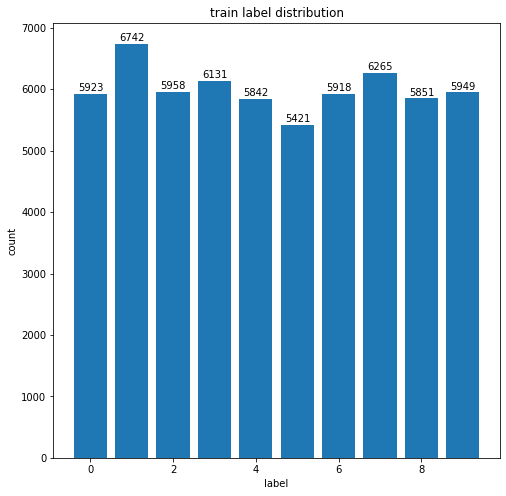

Test size: 10000


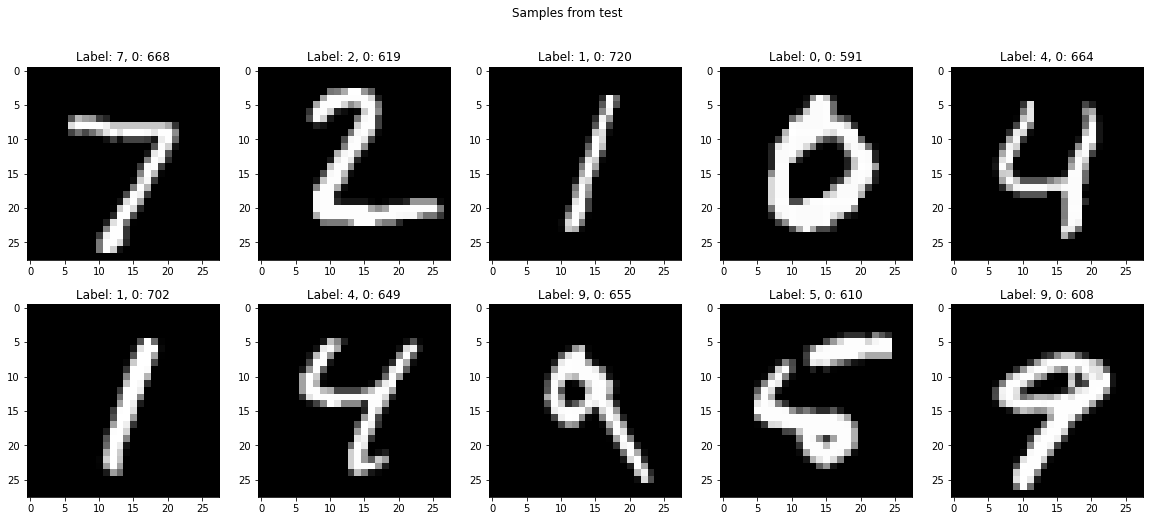

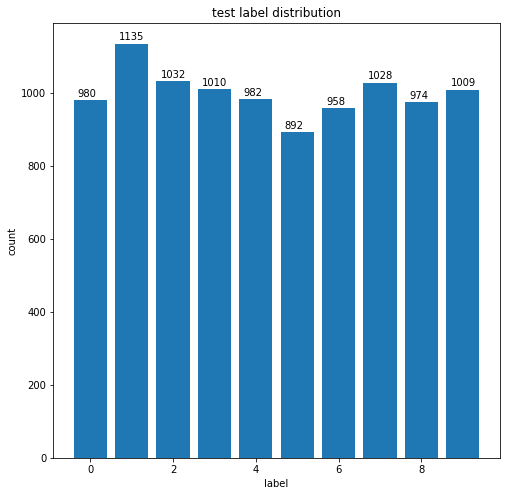

In [2]:
mnist_train = datasets.MNIST(root='./datasets', train=True, download=True)
mnist_test = datasets.MNIST(root='./datasets', train=False, download=True)
train_labels = pd.DataFrame(mnist_train.targets.numpy())
test_labels = pd.DataFrame(mnist_test.targets.numpy())

print(f'Train size: {len(mnist_train)}')
fig = plt.figure(figsize=(20, 8))
plt.suptitle('Samples from train')
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(mnist_train[i][0], cmap='gray')
  plt.title(f"Label: {mnist_train[i][1]}, 0: {mnist_train[i][0].histogram()[0]}")
plt.show()

fig = plt.figure(figsize=(8, 8))
plt.bar(range(0, 10), train_labels.value_counts().sort_index().values)
plt.xlabel('label')
plt.ylabel('count')
plt.title('train label distribution')
for index, value in enumerate(train_labels.value_counts().sort_index().values):
    plt.text(index-0.3, value+50, str(value))
plt.show()

print(f'Test size: {len(mnist_test)}')
fig = plt.figure(figsize=(20, 8))
plt.suptitle('Samples from test')
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(mnist_test[i][0], cmap='gray')
  plt.title(f"Label: {mnist_test[i][1]}, 0: {mnist_test[i][0].histogram()[0]}")
plt.show()

fig = plt.figure(figsize=(8, 8))
plt.bar(range(0, 10), test_labels.value_counts().sort_index().values)
plt.xlabel('label')
plt.ylabel('count')
plt.title('test label distribution')
for index, value in enumerate(test_labels.value_counts().sort_index().values):
    plt.text(index-0.3, value+10, str(value))
plt.show()

In [3]:
mnist_train = datasets.MNIST(root='./datasets', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./datasets', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(mnist_train, shuffle=True, batch_size=mnist_train.data.shape[0])
test_loader = DataLoader(mnist_test, shuffle=True, batch_size=mnist_test.data.shape[0])

# Calculate mean and standard deviation of pixels for later normalizations
for batch_idx, (data, target) in enumerate(train_loader):
    data = data.view(-1, 28 * 28)
    std = data.std().item()
    mean = data.mean().item()
print(f'mean: {mean:.4f}, std: {std:.4f}')

mean: 0.1307, std: 0.3081


In [4]:
class Configs:
    def __init__(self, n_epochs=10, batch_size=64, test_batch_size=1000, learning_rate=0.01, momentum=0.9, log_interval=1000):
        torch.manual_seed(9)
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.test_batch_size = test_batch_size
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.log_interval = log_interval

        self.train_configs = {'batch_size': self.batch_size}
        self.val_configs = {'batch_size': self.batch_size}
        self.test_configs = {'batch_size': self.test_batch_size}
        if torch.cuda.is_available():
            self.device = torch.device("cuda:0")
            cuda_configs = {'num_workers': 4, 'pin_memory': True, 'shuffle': True}
            self.train_configs.update(cuda_configs)
            self.val_configs.update(cuda_configs)
            self.test_configs.update(cuda_configs)

        else:
            self.device = torch.device("cpu")
            cpu_configs = {'num_workers': 4, 'pin_memory': True, 'shuffle': True}
            self.train_configs.update(cpu_configs)
            self.val_configs.update(cpu_configs)
            self.test_configs.update(cpu_configs)
    
    def get_train_kwargs(self):
        return self.train_configs

    def get_val_kwargs(self):
        return self.val_configs
    
    def get_test_kwargs(self):
        return self.test_configs

def convert_datasets(train_loader, val_loader, test_loader):
    X_train = np.array([])
    Y_train = np.array([])
    for idx, (data, label) in enumerate(train_loader):
        if X_train.size == 0:
            X_train = data.detach().numpy().reshape(-1, 28 * 28)
            Y_train = label.detach().numpy()
        else:
            X_train = np.concatenate((X_train, data.detach().numpy().reshape(-1, 28 * 28)))
            Y_train = np.concatenate((Y_train, label.detach().numpy()))

    X_test = np.array([])
    Y_test = np.array([])
    for idx, (data, label) in enumerate(test_loader):
        if X_test.size == 0:
            X_test = data.detach().numpy().reshape(-1, 28 * 28)
            Y_test = label.detach().numpy()
        else:
            X_test = np.concatenate((X_test, data.detach().numpy().reshape(-1, 28 * 28)))
            Y_test = np.concatenate((Y_test, label.detach().numpy()))
    return X_train, X_test, Y_train, Y_test

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        output = self.fc2(x)
        return output

def train(configs, model, train_loader, optimizer, epoch, criterion):
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(configs.device), target.to(configs.device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f'Train Epoch: {epoch} Loss: {np.mean(losses):.6f}')
    return np.mean(losses)

def validate(model, configs, val_loader, criterion, epoch):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(configs.device), target.to(configs.device)
            output = model(data)
            loss = criterion(output, target).item()
            losses.append(loss)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    avg_loss = np.mean(losses)
    accuracy = 100. * correct / len(val_loader.dataset)
    
    print(f'\tValidation Average Loss: {avg_loss:.4f}; Validation Accuracy: {correct}/{len(val_loader.dataset)} ({accuracy:.3f}%)\n')
    
    return avg_loss, accuracy

def test(model, configs, test_loader, criterion):
    model.eval()
    losses = []
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(configs.device), target.to(configs.device)
            output = model(data)
            loss = criterion(output, target).item()
            losses.append(loss)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    avg_loss = np.mean(losses)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f'Test Average Loss: {np.mean(losses):.4f}; Test Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.3f}%)')


### Hyperparameters:
- Epoch: 10.
- Batch size: 64. Faster training yet still generalize well. For SGD, large batch size will degrade the quality of model.
- Test batch size: 1000 for faster inference. Total 10 batches, 10000 samples.
- Learning rate: 0.01. Default learning rate for SGD. Larger learning rates make the algorithm take huge steps down the slope and it might jump across the minimum point thereby missing it.
- Momentum: 0.9. Suggested momentum for SGD which reduce oscillation and have faster convergence.
- Regularization: l2 regularized SGD may be suboptimal for the true loss.
- Loss function: Cross-Entropy is used as it is preferred for classification problem.

In [5]:
# define model configs
configs = Configs(n_epochs=10, batch_size=64, test_batch_size=1000, learning_rate=0.01, momentum=0.9, log_interval=None)

In [6]:
# define data transformation
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# preprocess and split dataset
mnist_train = datasets.MNIST(root='./datasets', train=True, download=True, transform=transformer)
mnist_test = datasets.MNIST(root='./datasets', train=False, download=True, transform=transformer)
mnist_train, mnist_val = random_split(mnist_train, [int(len(mnist_train) * 0.8), int(len(mnist_train) * 0.2)])

# load dataset to pytorch dataloader
train_loader = DataLoader(mnist_train, **configs.get_train_kwargs())
val_loader = DataLoader(mnist_val, **configs.get_val_kwargs())
test_loader = DataLoader(mnist_test, **configs.get_test_kwargs())

# convert pytorch dataloader to numpy array for KNN
X_train, X_test, Y_train, Y_test = convert_datasets(train_loader, val_loader, test_loader)

In [7]:
# load config
model = Net().to(configs.device)

# define loss function
criterion = CrossEntropyLoss()

# define optimizer
optimizer = optim.SGD(model.parameters(), lr=configs.learning_rate, momentum=configs.momentum)

In [8]:
train_losses_epoch = []
val_losses_epoch = []
val_accuracies = []
for epoch in range(configs.n_epochs):
    # train
    train_loss = train(configs, model, train_loader, optimizer, epoch, criterion)
    train_losses_epoch.append(train_loss)

    # validate
    val_loss, val_accuracy = validate(model, configs, val_loader, criterion, epoch)
    val_losses_epoch.append(val_loss)
    val_accuracies.append(val_accuracy)

Train Epoch: 0 Loss: 0.293405
	Validation Average Loss: 0.1568; Validation Accuracy: 11465/12000 (95.542%)

Train Epoch: 1 Loss: 0.123234
	Validation Average Loss: 0.1125; Validation Accuracy: 11597/12000 (96.642%)

Train Epoch: 2 Loss: 0.082417
	Validation Average Loss: 0.0982; Validation Accuracy: 11643/12000 (97.025%)

Train Epoch: 3 Loss: 0.060734
	Validation Average Loss: 0.0887; Validation Accuracy: 11681/12000 (97.342%)

Train Epoch: 4 Loss: 0.046937
	Validation Average Loss: 0.0819; Validation Accuracy: 11715/12000 (97.625%)

Train Epoch: 5 Loss: 0.035706
	Validation Average Loss: 0.0792; Validation Accuracy: 11712/12000 (97.600%)

Train Epoch: 6 Loss: 0.028069
	Validation Average Loss: 0.0756; Validation Accuracy: 11717/12000 (97.642%)

Train Epoch: 7 Loss: 0.022259
	Validation Average Loss: 0.0741; Validation Accuracy: 11733/12000 (97.775%)

Train Epoch: 8 Loss: 0.017079
	Validation Average Loss: 0.0740; Validation Accuracy: 11740/12000 (97.833%)

Train Epoch: 9 Loss: 0.01313

In [9]:
# inference
test(model, configs, test_loader, criterion)

Test Average Loss: 0.0641; Test Accuracy: 9793/10000 (97.930%)


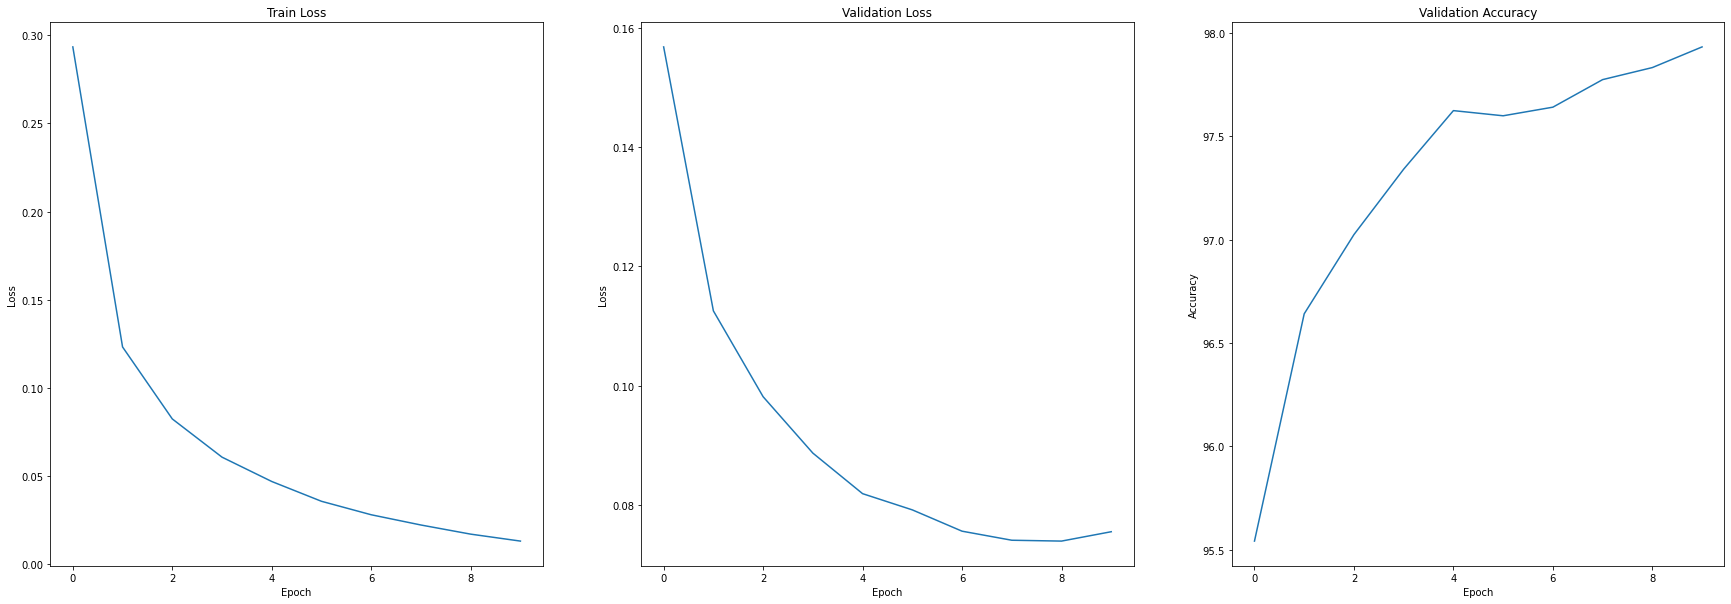

In [10]:
# plot training and validation loss and validation accuracy
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].plot(np.arange(len(train_losses_epoch)), train_losses_epoch)
ax[0].title.set_text('Train Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(np.arange(len(val_losses_epoch)), val_losses_epoch)
ax[1].title.set_text('Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[2].plot(np.arange(len(val_accuracies)), val_accuracies)
ax[2].title.set_text('Validation Accuracy')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Accuracy')
plt.show()

In [11]:
# bulid knn classifier
clf = neighbors.KNeighborsClassifier()
clf = clf.fit(X_train, Y_train)

KNN Accuracy: 9677/10000 (96.770%)


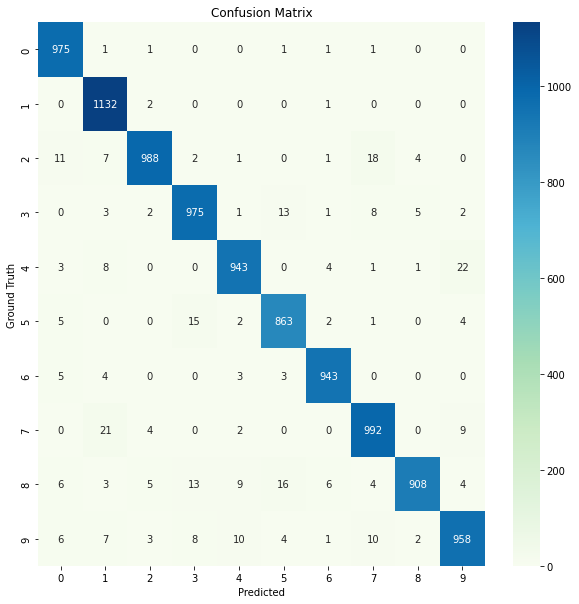

In [12]:
# make prediction
Y_pred = clf.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f'KNN Accuracy: {(np.array(Y_test) == np.array(Y_pred)).sum()}/{len(Y_test)} ({100. * accuracy:.3f}%)')

# calculate confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap='GnBu', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.show()

### Compare two models
#### Default KNN is much faster but a little bit less accurate than 2-layer NN on the same train and test dataset. KNN only requires tuning one parameter and NN requires tuning multiple parameters. When we have enough time to train and tune a NN model, it is better than KNN. When we don't have much time or have no time and need a model immediately, KNN is a better option to use. However, this is just a 2-layer NN, simply increasing the layer of NN can give more powerful model. In other words, the theoretical performance of a NN is better than KNN. Therefore, generally NN is a better model for this task as the time difference is tolerable and accuracy of NN is higher.